# Evaluating Earthquake Damage in Nepal 

## Executive Summary

The culminating task for the [Microsoft Professional Program in Data Science](https://academy.microsoft.com/en-us/professional-program/tracks/data-science/) was to use damage data from the 2015 Gorkha earthquake in Nepal to build a machine learning model that could predict the damage a building might experience in an earthquake.  While our data set is quite small and might not generalize to other locations very well, a more robust version of this model could be used by city planners or insurance companies in assessing the risk of an earthquake. 

This report will review data exploration that was done to examine the relationship between features that were available in the data using descriptive statstics and data visualization.  These finding lead us to know what to exclude from the model as well as suggested what would likely help us distinguish between the three damage classes. We will then review the models which were built for the problem, and discuss their criticisms. 

Our best models were able to achieve f1 micro scores of 0.703 on the test set hosted on DrivenData, and was an ensamble of two logistic regression models, two random forests, and a neural network. After modeling, we were also interested in applying the permutation importance method as a way to interpret the model and how it used the features. 

From our data exploration and permutaion importance analysis we found that these features were important parts of the prediction:

  * geo_level_id_1 and 2: Certain areas were more likely to have greater amounts of damage.
  * age: Older building experienced more damage.
  * area: Buildings more area tended to sustain less damage.
  * height: Taller building were at risk for more damage. 
  * superstructure: corrlated with higher (adobe, stone) or lower (cement/rc) damage grades
 
Finally, since this report is developed in Jupyter we will use Python to display some of the information and visuals throughout.  However, it is not the notebook where the model was original developed.  To review a notebook of the more technical model building process and to see some of the raw results, you can go to [my repository on GitHub.](https://github.com/mrklees/Data-Science-Capstone/blob/master/Earthquake%20Damage%20Model.ipynb)

## Exploring the Available Data

The entire game of modeling is based on the idea that there is information hidden in our data, and that these patterns can be figured out.  However when we are given a number of different variables, a first important task is get a sense of which variables might have the most information about how to distinguish between the target classes.  To this end data visualization is a very helpful tool in identifying which variables have the most visible trends with our target.

In [2]:
# These are our main data structures
import pandas as pd
import numpy as np

# These packages are used for visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Training examples and labels are already split for us.  A quick check of the building_id variables
# confirms that they are ordered the same
data = pd.read_csv("data/train_values.csv")
labels = pd.read_csv("data/train_labels.csv")
# We'll merge the dataset for come convenience when visualizing
merged = data.merge(labels)
# The Test Data set
test = pd.read_csv("data/test_values.csv")

With the data loaded, we can view some quick and basic information about our data.

In [6]:
print(f"The training data set has {merged.shape[0]} records and {merged.shape[1]} columns")
print("Descriptive stats are easily available for numeric variables.")
data.describe().T

The training data set has 10000 records and 40 columns
Descriptive stats are easily available for numeric variables.


,count,mean,std,min,25%,50%,75%,max
building_id,10000.0,9987.1600,5800.800829,1.0,4998.75,9963.5,15044.75,19999.0
geo_level_1_id,10000.0,7.1356,6.225567,0.0,2.00,6.0,10.00,30.0
geo_level_2_id,10000.0,296.9303,279.390651,0.0,60.00,219.0,466.00,1411.0
geo_level_3_id,10000.0,2678.6179,2520.663769,0.0,606.75,1937.5,4158.00,12151.0
count_floors_pre_eq,10000.0,2.1467,0.736365,1.0,2.00,2.0,3.00,9.0
age,10000.0,25.3935,64.482893,0.0,10.00,15.0,30.00,995.0
area,10000.0,38.4381,21.265883,6.0,26.00,34.0,44.00,425.0
height,10000.0,4.6531,1.792842,1.0,4.00,5.0,5.00,30.0
has_superstructure_adobe_mud,10000.0,0.0897,0.285766,0.0,0.00,0.0,0.00,1.0
has_superstructure_mud_mortar_stone,10000.0,0.7626,0.425511,0.0,1.00,1.0,1.00,1.0


### Exploring the Distributions of Each Variable

I have a few things that I want to understand about a distribution when getting started on a project:
  * What are the distributions of each variable?
  * How are the features correllated with the response variable?
  * How are the feature correllated with each other?
  * Are there missing values?
  
#### Distributions of each variable

From these histograms I notice several things.  We have a mix of categorical and numeric variables which describe building attributes (like how tall it is), how it is used (industry, etc...), and its locations.  It's helpful to think of these features as falling into a few different categories.

Building Attributes:
  * age
  * area
  * has_superstructure
  * height
  * count_floors_pre_eq
  * land_surface_condition
  * foundation_type
  * roof_type
  * ground_floor_type
  * other_floor_type
  
Building Use:
  * legal_ownership_status
  * has_secondary_use
  * count_families

Building Location:
  * geo_level_1_id (least specific location)
  * geo_level_2_id
  * geo_level_3_id (most specific location)
  * land_surface_condition
  * position
  * plan_configuration
  
One way we explored the distributions of these variables was with a scatter matrix. 

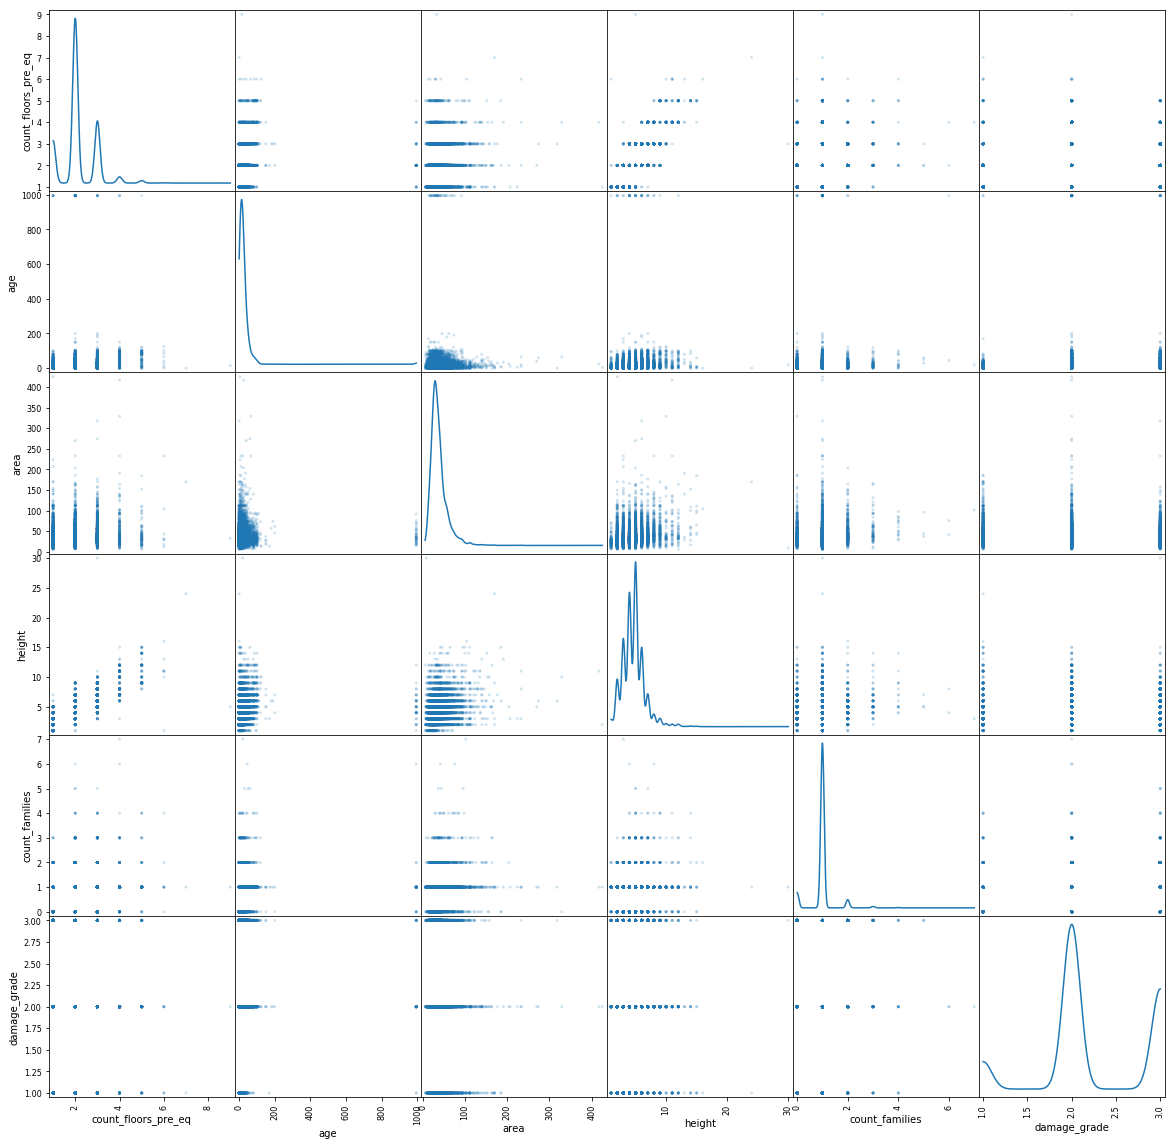

In [20]:
from pandas.plotting import scatter_matrix
cols = ['count_floors_pre_eq', 'age', 'area', 'height',
       'land_surface_condition', 'foundation_type', 'roof_type',
       'ground_floor_type', 'other_floor_type', 'position',
       'plan_configuration','legal_ownership_status', 'count_families','damage_grade']
scatter_matrix(merged[cols], alpha=0.2, figsize=(20, 20), diagonal='kde')
plt.show()

### Cross Variable Comparisons

As we look across some of the numeric variables like age, height, and area we can see that these features will be very informative in helping us distringuish between damage grades 1 and the others.  However, grades 2 and 3 are closer together it seems likely that we'll have a harder time distinsuishing between them. 

C:\Anaconda3\envs\bayes-gpu\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


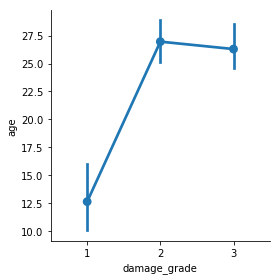

In [74]:
# How does Building Age correspond to damage grade?
sns.factorplot(x="damage_grade", y="age", data=merged)
# Observe that the average age for 1st grade damage was significantly lower than 2's and 3's. 

C:\Anaconda3\envs\bayes-gpu\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


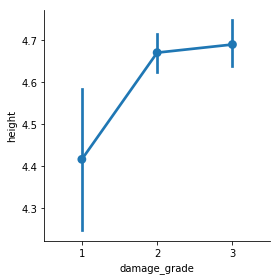

In [75]:
# Building Height versus Damage Grade
sns.factorplot(x="damage_grade", y="height", data=merged)
# Building height for grade 1's was slightly lower, though perhaps not significantly different 
# from 2's and 3's.  Maybe 2's and 3's contain more outliers though.

C:\Anaconda3\envs\bayes-gpu\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


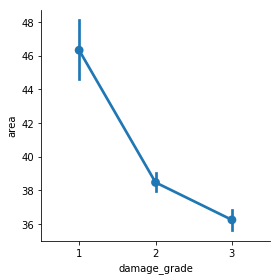

In [76]:
# Building Area versus Damage Grade
sns.factorplot(x="damage_grade", y="area", data=merged)
# We notice that lower damage grades seem to correspond to 

C:\Anaconda3\envs\bayes-gpu\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


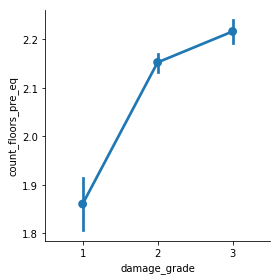

In [77]:
# Building Area versus Damage Grade
sns.factorplot(x="damage_grade", y="count_floors_pre_eq", data=merged)
# We notice that lower damage grades seem to correspond to

### Correlation

Finally, it was helpful to explore the correlations of our features with our main target and with each other.  Below we display the correlation matrix for all variables in a headmap.  A few things to notice, that certain super structures seem to be highly corrlated with higher (adobe, stone) or lower (cement/rc) damage grades.  Area also is clearly negative and floor count is clearly positive.  It's important not to overstate the value pearson correlation, but it doe seem to give us some hints.

has_superstructure_cement_mortar_brick   -0.233398
has_superstructure_rc_engineered         -0.179761
has_superstructure_rc_non_engineered     -0.156371
area                                     -0.114775
has_secondary_use                        -0.087286
has_secondary_use_hotel                  -0.085269
has_superstructure_timber                -0.080558
has_superstructure_cement_mortar_stone   -0.073337
has_superstructure_bamboo                -0.072327
geo_level_1_id                           -0.064084
has_secondary_use_rental                 -0.063367
has_secondary_use_school                 -0.041652
has_secondary_use_other                  -0.031927
has_secondary_use_institution            -0.029296
has_superstructure_other                 -0.019515
has_secondary_use_gov_office             -0.017306
has_secondary_use_agriculture            -0.013333
has_secondary_use_industry               -0.011504
building_id                              -0.008632
geo_level_2_id                 

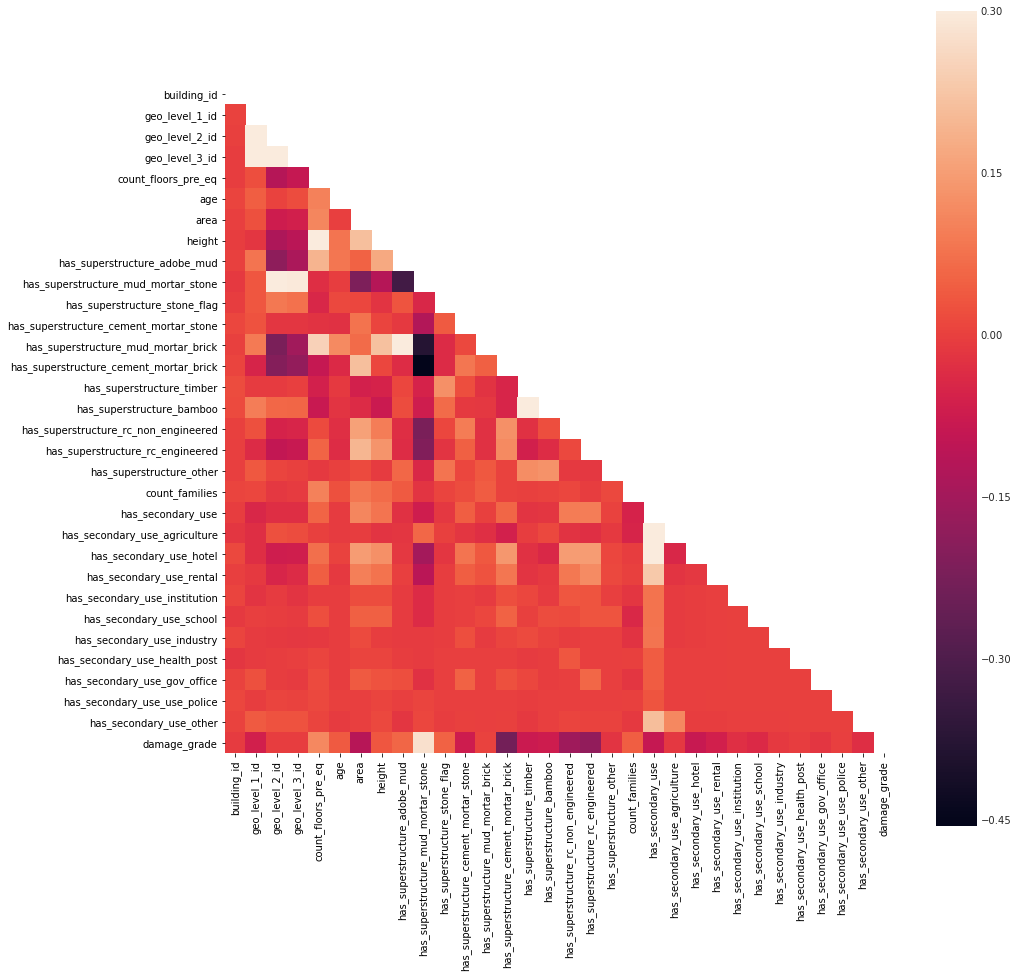

In [21]:
f, axs = plt.subplots(1, figsize=(15, 15))
cor = merged.corr()
print("Features With Associated Correlation in Increasing Order")
print(cor['damage_grade'].sort_values())
mask = np.zeros_like(cor)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(cor, mask=mask, vmax=.3, square=True, ax=axs)
plt.show()

## Data Preparation

The final phases of data preparation were to put the data into [Feature Tools.](https://www.featuretools.com/)  It's a great tool for ensuring your data is clean, and also has a lot of support for automated feature engineering although we don't take advantage of that here.  Our primary goals were to ensure that:

  * Each column had the correct data type 
  * Categorical variables are one hot encoded
  * All columns are normalized
  * Dropping features with no information value (building_id)

#### Addressing Class Imbalance Problem

We noticed in the data that there is a severe class imbalance problem.  Class 2 is easily the largest, follow by class 3 which is about 50% of class 2 and class 1 which is about 15% the size of class 2. There are a number of approaches to this problem to consider:

  1. Undersample
  2. Oversample
  3. Penalize weights
  
1 and 2 can be facilitated by the imbalance-learn python package, and weight penalization is natively supported by many scikit-learn models.  

If these three methods don't get us close enough, we could also try breaking up this problem.  That is, first trying to predict class 1's with one model, and then trying to differentiate class 2 and 3's with a second.  I am often of the opinion that is better to try to get a single model to learn those more complex relationships, but so far that doesn't seem to be happening.

In [64]:
import featuretools as ft

def build_es(data):
    # Feature tools will do its best auto detect the dtypes of our variables.  However we'll need to make some corrections.
    dtypes = {
        'geo_level_1_id': ft.variable_types.Categorical,
        'geo_level_2_id': ft.variable_types.Categorical,
        'geo_level_3_id': ft.variable_types.Numeric,
        'has_superstructure_adobe_mud': ft.variable_types.Boolean,
        'has_superstructure_mud_mortar_stone': ft.variable_types.Boolean, 
        'has_superstructure_stone_flag': ft.variable_types.Boolean,
        'has_superstructure_cement_mortar_stone': ft.variable_types.Boolean,
        'has_superstructure_mud_mortar_brick': ft.variable_types.Boolean,
        'has_superstructure_cement_mortar_brick': ft.variable_types.Boolean, 
        'has_superstructure_timber': ft.variable_types.Boolean,
        'has_superstructure_bamboo': ft.variable_types.Boolean, 
        'has_superstructure_rc_non_engineered': ft.variable_types.Boolean,
        'has_superstructure_rc_engineered': ft.variable_types.Boolean, 
        'has_superstructure_other': ft.variable_types.Boolean,
        'has_secondary_use': ft.variable_types.Boolean,
        'has_secondary_use_agriculture': ft.variable_types.Boolean, 
        'has_secondary_use_hotel': ft.variable_types.Boolean,
        'has_secondary_use_rental': ft.variable_types.Boolean,
        'has_secondary_use_institution': ft.variable_types.Boolean,
        'has_secondary_use_school': ft.variable_types.Boolean, 
        'has_secondary_use_industry': ft.variable_types.Boolean,
        'has_secondary_use_health_post': ft.variable_types.Boolean, 
        'has_secondary_use_gov_office': ft.variable_types.Boolean,
        'has_secondary_use_use_police': ft.variable_types.Boolean, 
        'has_secondary_use_other': ft.variable_types.Boolean
    }
    
    # Start be definng an EntitySet.  This abstractly contains all data we'll use to train the model, potentially in multiple tables. 
    es = ft.EntitySet(id="Buildings")

    data = data.copy()
    data.reset_index(inplace=True)
    # With the container defined, we'll add our data
    es = es.entity_from_dataframe(entity_id='buildings',
                                  dataframe=data,
                                  variable_types=dtypes,
                                  index="index")

    # This method will traverse our categorical variables and identify interesting values to construct
    # where variables from
    es.add_interesting_values(max_values=50, verbose=False)

    return es

es = build_es(data)

# Yields our base feature matrix and defs
base_mat, base_defs = ft.dfs(entityset=es,
                               target_entity='buildings',
                               agg_primitives=[],
                               max_depth=2)

# Encode categorical features with one hot encoding using feature tools
basemat_encoded, base_encoded = ft.encode_features(base_mat, base_defs, include_unknown=False, top_n=1000,
                                                   to_encode=['geo_level_1_id', 'geo_level_2_id', 
                                                              'land_surface_condition', 'foundation_type',
                                                              'roof_type', 'ground_floor_type', 'other_floor_type',
                                                              'position', 'plan_configuration', 'legal_ownership_status'])
# Save the feature sets so that we can load them with our submission data
ft.save_features(base_encoded, "base_features")

base = basemat_encoded.drop(['building_id'], axis=1)

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV

def preprocessing(X, y=None):
    # At this point, any NA's can just be filled with 0.  
    X.fillna(0, inplace=True)
    # Drop columns which have no information value
    # X = drop_unused(X)
    # Drop any columns which only have a single value
    #X = drop_trivial(X)
    # Scale our numeric cols
    X = norm_cols(X)
    return X, y

def drop_trivial(data):
    """If a column only has 1 value, drop it"""
    for col in data.columns:
        if len(data[col].unique()) == 1:
            data.drop(col,inplace=True,axis=1)            
    return data

def norm_cols(data):
    # Identify columns in need of scaling by those who have more than two values
    numeric = list(data.loc[:, (data.apply(lambda x: len(x.unique())) > 2).values].columns)
    #numeric.remove('geo_level_3_id')
    scaler = RobustScaler()
    scaled = pd.DataFrame(scaler.fit_transform(data[numeric]), columns=numeric)
    for column in numeric:
        data[column] = scaled[column]
    return data

In [65]:
# Obtain our preprocessed data and split it into training and validations sets
X, y = preprocessing(base, labels.damage_grade)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, stratify=y)

C:\Anaconda3\envs\bayes-gpu\lib\site-packages\sklearn\model_selection\_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


## Statistical Modeling

Our primary strategy when modeling this problem was to try different types of models and then potentially combine them.  After much tinkering we landed on using 5 main models and then combined them into a voting classifier.  These models were a logistic regression classifier, another logistic classifier but with the SMOTE oversampling method in conjunction, a random forest, a random forest with class weighting applied, and finally a fully conected neural network. 

As each model was built, it was evaluated with cross validation over a training set and then evaluationed on a validation set with the f1 metric so as to best match the evaluator on the leaderboard.  Here is an example of these with the first logistic model trained.  For brevity, the remainder of the detail on each model is contained in the [model report on GitHub.](https://github.com/mrklees/Data-Science-Capstone/blob/master/Earthquake%20Damage%20Model.ipynb)

In [66]:
# Since we are being score on f1_score, we'll use this as our main measure of model fit
from sklearn.metrics import f1_score, classification_report
# This filter method will help when we have a lot of features.  We will also want to try
# PCA or some other form of dimensionality reduction as well. 
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import SGDClassifier

def cross_validate(model, X, y, n_folds=5, oversample=False):       
    skf = StratifiedKFold(n_folds)
    training_scores = []
    validation_scores = []
    
    for ts, vs in skf.split(X, y):
        xt, yt = X[ts, :], y.reshape(-1, 1)[ts, :]
        xv, yv = X[vs, :], y.reshape(-1, 1)[vs, :]
        if oversample:
            xt, yt = SMOTE(n_jobs=-1).fit_sample(xt, yt)
        model.fit(xt, yt)
        training_scores.append(score_model(model, xt, yt))
        val_score = score_model(model, xv, yv)
        print(val_score)
        validation_scores.append(val_score)
    training_scores = np.array(training_scores)
    validation_scores = np.array(validation_scores)
    print(f"Training Error was distributed with mean:{training_scores.mean()}, std: {training_scores.std()}")
    print(f"Validation Error was distributed with mean:{validation_scores.mean()}, std: {validation_scores.std()}")  

def make_predictions(model, X, y):
    testing = X.copy()
    testing['preds'] = model.predict(X)
    testing['actual'] = y.values
    testing['correct'] = np.where(testing.preds == testing.actual, 1, 0)
    return testing
    
def plot_error_by_class(model, X, y):
    testing = make_predictions(model, X, y)

    # Our accuracy for each class
    # Clearly the class imbalance problem 
    sns.factorplot(x="actual", y='correct', data=testing)
    plt.show()

In [67]:
selector = SelectKBest(k='all')
Xfiltered = pd.DataFrame(selector.fit_transform(X_train, y_train))
logit_model = SGDClassifier(loss='log', penalty='elasticnet', max_iter=1000000, tol=1e-12, alpha=0.0001, l1_ratio=0.55)
cross_validate(logit_model, Xfiltered.values, y_train.values, n_folds=5, oversample=False)

C:\Anaconda3\envs\bayes-gpu\lib\site-packages\sklearn\utils\__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):
C:\Anaconda3\envs\bayes-gpu\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  34  824  852  917  918  921  927  960  977  992  997 1005 1008 1016
 1029 1031 1039 1044 1046 1047 1053 1061 1063 1070 1071 1072] are constant.
  UserWarning)
C:\Anaconda3\envs\bayes-gpu\lib\site-packages\sklearn\utils\validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.6355762824783477
0.6522318454363758
0.638
0.6270847231487658
0.6677785190126752
Training Error was distributed with mean:0.7206334438472253, std: 0.010105768982371489
Validation Error was distributed with mean:0.6441342740152329, std: 0.01432603717716236


In [68]:
# Apply KBest to validation dataset
X_test_filtered = pd.DataFrame(selector.transform(X_test))
# Train model on all data
logit_model.fit(Xfiltered.values, y_train.values)
target_names = ['Damage Grade 1', 'Damage Grade 2', 'Damage Grade 3']
print(classification_report(y_test, logit_model.predict(X_test), target_names=target_names))

C:\Anaconda3\envs\bayes-gpu\lib\site-packages\sklearn\utils\__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


                precision    recall  f1-score   support

Damage Grade 1       0.55      0.43      0.48       235
Damage Grade 2       0.72      0.77      0.74      1409
Damage Grade 3       0.67      0.64      0.65       856

   avg / total       0.69      0.69      0.69      2500



C:\Anaconda3\envs\bayes-gpu\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


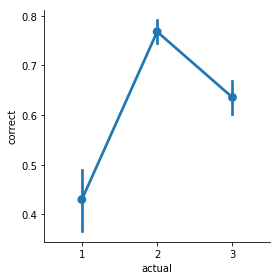

In [69]:
plot_error_by_class(logit_model, X_test_filtered, y_test)

In [75]:
# Our Logistic Regression responded in an interesting way with oversampling, and was better as predicting damage 1 and 3 than class_weights
selector = SelectKBest(k='all')
Xfiltered = pd.DataFrame(selector.fit_transform(X_train, y_train))
logit_model_oversampled = SGDClassifier(loss='log', penalty='elasticnet', max_iter=1000000, tol=1e-12, alpha=0.0001, l1_ratio=0.55)
cross_validate(logit_model_oversampled, Xfiltered.values, y_train.values, n_folds=10, oversample=True)

C:\Anaconda3\envs\bayes-gpu\lib\site-packages\sklearn\utils\__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):
C:\Anaconda3\envs\bayes-gpu\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  34  824  852  917  918  921  927  960  977  992  997 1005 1008 1016
 1029 1031 1039 1044 1046 1047 1053 1061 1063 1070 1071 1072] are constant.
  UserWarning)
C:\Anaconda3\envs\bayes-gpu\lib\site-packages\sklearn\utils\validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.6351531291611185


C:\Anaconda3\envs\bayes-gpu\lib\site-packages\sklearn\utils\validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.6364846870838882


C:\Anaconda3\envs\bayes-gpu\lib\site-packages\sklearn\utils\validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.6351531291611185


C:\Anaconda3\envs\bayes-gpu\lib\site-packages\sklearn\utils\validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.644


C:\Anaconda3\envs\bayes-gpu\lib\site-packages\sklearn\utils\validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.664


C:\Anaconda3\envs\bayes-gpu\lib\site-packages\sklearn\utils\validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.6373333333333333


C:\Anaconda3\envs\bayes-gpu\lib\site-packages\sklearn\utils\validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.6293333333333333


C:\Anaconda3\envs\bayes-gpu\lib\site-packages\sklearn\utils\validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.5874499332443258


C:\Anaconda3\envs\bayes-gpu\lib\site-packages\sklearn\utils\validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.6408544726301736


C:\Anaconda3\envs\bayes-gpu\lib\site-packages\sklearn\utils\validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.6568758344459279
Training Error was distributed with mean:0.7712584581414405, std: 0.006030150285925423
Validation Error was distributed with mean:0.6366637852393219, std: 0.01925606596919242


In [76]:
logit_model_oversampled
X_test_filtered = pd.DataFrame(selector.transform(X_test))
target_names = ['Damage Grade 1', 'Damage Grade 2', 'Damage Grade 3']
print(classification_report(y_test, logit_model_oversampled.predict(X_test_filtered.values), target_names=target_names))

C:\Anaconda3\envs\bayes-gpu\lib\site-packages\sklearn\utils\__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


                precision    recall  f1-score   support

Damage Grade 1       0.39      0.73      0.51       235
Damage Grade 2       0.75      0.59      0.66      1409
Damage Grade 3       0.62      0.69      0.66       856

   avg / total       0.67      0.64      0.64      2500



C:\Anaconda3\envs\bayes-gpu\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


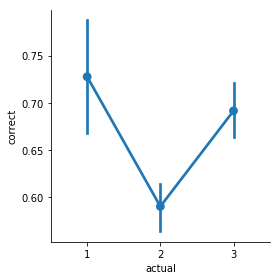

In [77]:
# Notice that this model is much better at predicting 
plot_error_by_class(logit_model_oversampled, X_test_filtered, y_test)

## Feature Importance

With a model built, there is one last opportunity to investigate feature importance by using the [permutation importance method.](https://eli5.readthedocs.io/en/latest/blackbox/permutation_importance.html)  In this approach the model is repeatedly trained where a single feature is replaced with noise.  The new model is then scored and change in score from the original model is calculated.  This gives us yet another view into the importance of each feature, though this time through the lens of the model itself.  

Looking at this analysis, we can see that geographic location was a critically valuable data point, and in particular many of the geo_level_1 ids had the highest positive importances.  We also see that a certain building position, foundation, and superstructure inluenced model greately. 

In [70]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(logit_model, scoring='f1_micro').fit(X_test, y_test.values)

In [71]:
feature_importances = pd.DataFrame(X.columns, columns=['Features'])

In [72]:
feature_importances['importance'] = perm.feature_importances_
feature_importances['importance_sd'] = perm.feature_importances_std_

In [73]:
feature_importances.sort_values('importance')

,Features,importance,importance_sd
47,geo_level_1_id = 4,-0.00160,0.001697
249,geo_level_2_id = 108,-0.00160,0.000253
183,geo_level_2_id = 184,-0.00104,0.000320
287,geo_level_2_id = 360,-0.00096,0.000196
116,geo_level_2_id = 56,-0.00088,0.000392
1081,has_superstructure_bamboo,-0.00088,0.002522
280,geo_level_2_id = 422,-0.00080,0.000000
96,geo_level_2_id = 25,-0.00080,0.000358
197,geo_level_2_id = 191,-0.00080,0.000506
601,geo_level_2_id = 407,-0.00080,0.000358


# Conclusion